# Inference

## Copy tokenizer

In [1]:
from transformers import AutoTokenizer

# 1. Specify the name of the Hugging Face model
model_name = "Qwen/Qwen3-0.6B" 

# 2. Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 3. Define the local directory where you want to save the tokenizer
local_directory = "./final_chess_model"

# 4. Save the tokenizer to the local directory
tokenizer.save_pretrained(local_directory)

print(f"Tokenizer for '{model_name}' saved to '{local_directory}'")

Tokenizer for 'Qwen/Qwen3-0.6B' saved to './final_chess_model'


# Compilation

After completing the fine-tuning process, the next step is to compile the trained model for AWS Trainium inference using the Hugging Face Optimum Neuron toolchain.
Neuron compilation optimizes the model graph and converts it into a Neuron Executable File Format (NEFF), enabling efficient execution on NeuronCores.

In [2]:
!optimum-cli export neuron \
  --model "./final_chess_model" \
  --task text-generation \
  --sequence_length 2048 \
  --batch_size 1 \
  ./final_chess_model_compiled

INFO 11-07 17:57:35 [__init__.py:36] Available plugins for group vllm.platform_plugins:
INFO 11-07 17:57:35 [__init__.py:38] - optimum_neuron -> optimum.neuron.vllm.plugin:register
INFO 11-07 17:57:35 [__init__.py:41] All plugins in this group will be loaded. Set `VLLM_PLUGINS` to control which plugins to load.
INFO 11-07 17:57:35 [__init__.py:207] Platform plugin optimum_neuron is activated
WARNING 11-07 17:57:36 [_custom_ops.py:20] Failed to import from vllm._C with ImportError('libcuda.so.1: cannot open shared object file: No such file or directory')
/opt/aws_neuronx_venv_pytorch_latest/lib/python3.10/site-packages/neuronx_distributed/parallel_layers/layers.py:14: DeprecationWarning: torch_neuronx.nki_jit is deprecated, use nki.jit instead.
  from .mappings import (
/opt/aws_neuronx_venv_pytorch_latest/lib/python3.10/site-packages/neuronx_distributed/parallel_layers/layers.py:14: DeprecationWarning: torch_neuronx.nki_jit is deprecated, use nki.jit instead.
  from .mappings import (


# Inference

We will install the Optimum Neuron vllm library.  Then, run inference using the compiled model.

In [3]:
%pip install -q optimum-neuron[vllm]


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Now you can run the batch inference example below

In [3]:
import os
import json
from vllm import LLM, SamplingParams
import re

# Load the compiled model
llm = LLM(
    model="./final_chess_model_compiled",
    max_num_seqs=1,
    max_model_len=2048,
    tensor_parallel_size=2,
)

def create_conversation(input_text):
    """Create conversation format matching the training script."""
    return [
        {
            "role": "system",
            "content": "Classify the better move. Output format: MoveA or MoveB"
        },
        {
            "role": "user",
            "content": input_text
        },
    ]

def extract_move_answer(text):
    """Extract MoveA or MoveB from the generated text - looking at the END of the text."""
    # Look at the last 200 characters where the answer should be
    text_end = text[-200:] if len(text) > 200 else text
    
    # Look for MoveA or MoveB (case insensitive, with optional colon and move notation)
    match = re.search(r'Move([AB])(?::[a-z0-9]+)?', text_end, re.IGNORECASE)
    if match:
        return f"MOVE{match.group(1).upper()}"
    
    # If not found at the end, search the whole text (take the LAST occurrence)
    matches = list(re.finditer(r'Move([AB])(?::[a-z0-9]+)?', text, re.IGNORECASE))
    if matches:
        return f"MOVE{matches[-1].group(1).upper()}"
    
    return None

def normalize_expected_answer(expected_output):
    """Normalize the expected answer to just MOVEA or MOVEB."""
    match = re.search(r'Move([AB])', expected_output, re.IGNORECASE)
    if match:
        return f"MOVE{match.group(1).upper()}"
    return expected_output.upper()

# Load the chess dataset
print("Loading chess dataset...")
with open('/home/ubuntu/environment/distillation/data/chess_output.json', 'r') as f:
    chess_data = json.load(f)

# Filter out samples with errors
chess_data = [item for item in chess_data if 'error' not in item]
print(f"Loaded {len(chess_data)} valid chess samples")

# Create prompts using the tokenizer's chat template
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("./final_chess_model_compiled")

prompts = []
for item in chess_data:
    conversation = create_conversation(item['input'])
    formatted_prompt = tokenizer.apply_chat_template(
        conversation,
        tokenize=False,
        add_generation_prompt=True
    )
    prompts.append(formatted_prompt)

print(f"Created {len(prompts)} prompts for inference")

# Run inference with full sequence length
print("\nRunning inference on all samples...")
print("Using max_tokens=2048 to ensure complete responses")
sampling_params = SamplingParams(max_tokens=2048, temperature=0.0)  # Full sequence length
outputs = llm.generate(prompts, sampling_params)

# Process results
results = []
teacher_correct = 0
student_correct = 0

for idx, output in enumerate(outputs):
    item = chess_data[idx]
    generated_text = output.outputs[0].text.strip()
    
    # Extract the teacher's answer
    teacher_full_response = item['response']['generated_text']
    if 'assistant' in teacher_full_response:
        teacher_response_part = teacher_full_response.split('assistant')[-1].strip()
    else:
        teacher_response_part = teacher_full_response
    
    teacher_answer = extract_move_answer(teacher_response_part)
    
    # Extract the student's answer
    student_answer = extract_move_answer(generated_text)
    
    # Get the expected (correct) answer and normalize it
    expected_answer = normalize_expected_answer(item['expected_output'])
    
    # Check correctness
    teacher_is_correct = (teacher_answer == expected_answer) if teacher_answer else False
    student_is_correct = (student_answer == expected_answer) if student_answer else False
    
    if teacher_is_correct:
        teacher_correct += 1
    if student_is_correct:
        student_correct += 1
    
    results.append({
        'question_id': idx,
        'input': item['input'],
        'expected_answer': expected_answer,
        'teacher_answer': teacher_answer,
        'teacher_correct': teacher_is_correct,
        'student_answer': student_answer,
        'student_correct': student_is_correct,
        'student_raw_output': generated_text
    })
    
    # Print progress every 100 samples
    if (idx + 1) % 100 == 0:
        print(f"Processed {idx + 1}/{len(chess_data)} samples...")
        print(f"  Current Teacher Accuracy: {teacher_correct}/{idx+1} ({teacher_correct/(idx+1)*100:.1f}%)")
        print(f"  Current Student Accuracy: {student_correct}/{idx+1} ({student_correct/(idx+1)*100:.1f}%)")

# Calculate statistics
total_samples = len(results)
teacher_accuracy = (teacher_correct / total_samples) * 100
student_accuracy = (student_correct / total_samples) * 100

summary = {
    'total_samples': total_samples,
    'teacher_correct': teacher_correct,
    'teacher_accuracy': teacher_accuracy,
    'student_correct': student_correct,
    'student_accuracy': student_accuracy,
    'results': results
}

# Save results to file
output_file = 'chess_evaluation_results.json'
with open(output_file, 'w') as f:
    json.dump(summary, f, indent=2)

print(f"\n{'='*80}")
print(f"Evaluation Complete!")
print(f"{'='*80}")
print(f"Total Samples: {total_samples}")
print(f"Teacher Accuracy: {teacher_correct}/{total_samples} ({teacher_accuracy:.2f}%)")
print(f"Student Accuracy: {student_correct}/{total_samples} ({student_accuracy:.2f}%)")
print(f"\nResults saved to: {output_file}")

# Show a few examples for verification
print(f"\n{'='*80}")
print("Sample Results (first 5):")
print(f"{'='*80}")
for i in range(min(5, len(results))):
    r = results[i]
    print(f"\nQuestion {i+1}:")
    print(f"  Expected: {r['expected_answer']}")
    print(f"  Teacher:  {r['teacher_answer']} {'✓' if r['teacher_correct'] else '✗'}")
    print(f"  Student:  {r['student_answer']} {'✓' if r['student_correct'] else '✗'}")
    print(f"  Student output length: {len(r['student_raw_output'])} chars")
    if r['student_answer']:
        print(f"  Student raw (last 100 chars): ...{r['student_raw_output'][-100:]}")


INFO 11-07 18:00:57 [__init__.py:36] Available plugins for group vllm.platform_plugins:
INFO 11-07 18:00:57 [__init__.py:38] - optimum_neuron -> optimum.neuron.vllm.plugin:register
INFO 11-07 18:00:57 [__init__.py:41] All plugins in this group will be loaded. Set `VLLM_PLUGINS` to control which plugins to load.
INFO 11-07 18:00:57 [__init__.py:207] Platform plugin optimum_neuron is activated
WARNING 11-07 18:00:58 [_custom_ops.py:20] Failed to import from vllm._C with ImportError('libcuda.so.1: cannot open shared object file: No such file or directory')
INFO 11-07 18:00:58 [utils.py:328] non-default args: {'max_model_len': 2048, 'tensor_parallel_size': 2, 'max_num_seqs': 1, 'disable_log_stats': True, 'model': './final_chess_model_compiled'}
INFO 11-07 18:01:07 [__init__.py:742] Resolved architecture: Qwen3ForCausalLM
INFO 11-07 18:01:07 [__init__.py:1815] Using max model len 2048
WARNING 11-07 18:01:07 [arg_utils.py:1801] device type=cpu is not supported by the V1 Engine. Falling back 

/opt/aws_neuronx_venv_pytorch_latest/lib/python3.10/site-packages/neuronx_distributed/parallel_layers/layers.py:14: DeprecationWarning: torch_neuronx.nki_jit is deprecated, use nki.jit instead.
  from .mappings import (
/opt/aws_neuronx_venv_pytorch_latest/lib/python3.10/site-packages/neuronx_distributed/parallel_layers/layers.py:14: DeprecationWarning: torch_neuronx.nki_jit is deprecated, use nki.jit instead.
  from .mappings import (
/opt/aws_neuronx_venv_pytorch_latest/lib/python3.10/site-packages/neuronx_distributed/parallel_layers/layers.py:14: DeprecationWarning: torch_neuronx.nki_jit is deprecated, use nki.jit instead.
  from .mappings import (
/opt/aws_neuronx_venv_pytorch_latest/lib/python3.10/site-packages/neuronx_distributed/modules/moe/blockwise.py:68: DeprecationWarning: torch_neuronx.nki_jit is deprecated, use nki.jit instead.
  component, error = import_nki(config)
/opt/aws_neuronx_venv_pytorch_latest/lib/python3.10/site-packages/neuronx_distributed/modules/moe/blockwise

[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0

/opt/aws_neuronx_venv_pytorch_latest/lib/python3.10/site-packages/optimum/neuron/models/inference/llama/modeling_llama.py:33: DeprecationWarning: torch_neuronx.nki_jit is deprecated, use nki.jit instead.
  from ..backend.modules.attention.attention_base import NeuronAttentionBase
INFO:Neuron:Loading sharded checkpoint from final_chess_model_compiled/checkpoint/weights


WARNING 11-07 18:01:29 [__init__.py:3804] Current vLLM config is not set.
WARNING 11-07 18:01:29 [__init__.py:3804] Current vLLM config is not set.
INFO 11-07 18:01:29 [executor_base.py:114] # neuron blocks: 2, # CPU blocks: 0
INFO 11-07 18:01:29 [executor_base.py:119] Maximum concurrency for 2048 tokens per request: 2.00x
INFO 11-07 18:01:29 [llm_engine.py:420] init engine (profile, create kv cache, warmup model) took 0.00 seconds
INFO 11-07 18:01:29 [importing.py:43] Triton is installed but 0 active driver(s) found (expected 1). Disabling Triton to prevent runtime errors.
INFO 11-07 18:01:29 [importing.py:63] Triton not installed or not compatible; certain GPU-related functions will not be available.
INFO 11-07 18:01:29 [llm.py:295] Supported_tasks: ['generate']
INFO 11-07 18:01:29 [__init__.py:36] No IOProcessor plugins requested by the model
Loading chess dataset...
Loaded 100 valid chess samples
Created 100 prompts for inference

Running inference on all samples...
Using max_token

Adding requests:   0%|          | 0/100 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/100 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed 100/100 samples...
  Current Teacher Accuracy: 59/100 (59.0%)
  Current Student Accuracy: 51/100 (51.0%)

Evaluation Complete!
Total Samples: 100
Teacher Accuracy: 59/100 (59.00%)
Student Accuracy: 51/100 (51.00%)

Results saved to: chess_evaluation_results.json

Sample Results (first 5):

Question 1:
  Expected: MOVEA
  Teacher:  MOVEA ✓
  Student:  MOVEA ✓
  Student output length: 6156 chars
  Student raw (last 100 chars): ...s better MoveA: MoveA is better MoveA: MoveA is better MoveA: MoveA is better MoveA: MoveA is better

Question 2:
  Expected: MOVEB
  Teacher:  MOVEB ✓
  Student:  MOVEA ✗
  Student output length: 7464 chars
  Student raw (last 100 chars): ...A is better MoveA is better MoveA is better MoveA is better MoveA is better MoveA is better MoveA is

Question 3:
  Expected: MOVEB
  Teacher:  MOVEA ✗
  Student:  MOVEA ✗
  Student output length: 6094 chars
  Student raw (last 100 chars): ...r moveA.
MoveA is better moveA.
MoveA is better moveA.
MoveA is better m

CHESS MOVE EVALUATION RESULTS

Dataset Size: 100 chess positions

Model                Correct         Incorrect       Accuracy       
----------------------------------------------------------------------
Teacher (Qwen3-30B)  59              41              59.00%
Student (Qwen3-0.6B) 51              49              51.00%
----------------------------------------------------------------------

Agreement Analysis:
  Both Correct:                    34 (34.0%)
  Both Wrong:                      24 (24.0%)
  Teacher Right, Student Wrong:    25 (25.0%)
  Student Right, Teacher Wrong:    17 (17.0%)

Knowledge Retention: 57.63%
  (Student correctly answered 57.6% of questions the teacher got right)

Visualization saved to: chess_evaluation_results.png


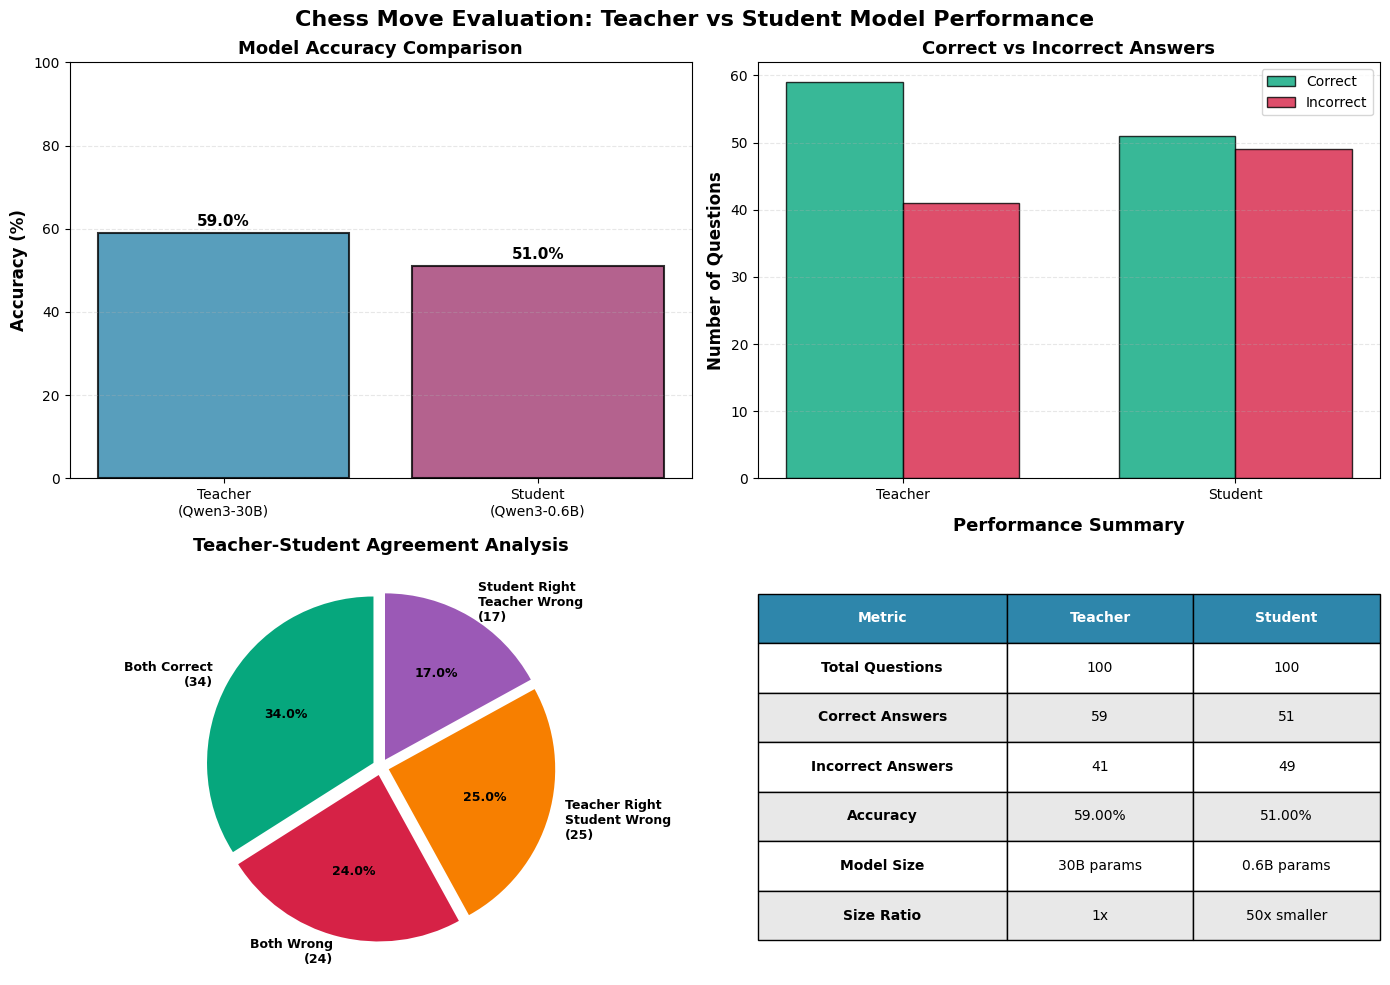


SAMPLE PREDICTIONS (First 5 questions)

Question 1:
  Input: The FEN of the given chess board is "1r4k1/4nppp/8/4Pb2/8/1P5P/r1PR4/3R3K w - - 0 27". Which move is...
  Expected: MOVEA
  Teacher: MOVEA ✓
  Student: MOVEA ✓

Question 2:
  Input: The FEN of the given chess board is "7r/pp4k1/8/3p1pp1/3N1q2/2P4P/PP4Q1/6K1 w - - 0 39". Which move ...
  Expected: MOVEB
  Teacher: MOVEB ✓
  Student: MOVEA ✗

Question 3:
  Input: The FEN of the given chess board is "4k2r/p4ppp/2p3P1/2b1P2n/8/P1N5/1P1rQ1PP/R4R1K b k - 0 20". Whic...
  Expected: MOVEB
  Teacher: MOVEA ✗
  Student: MOVEA ✗

Question 4:
  Input: The FEN of the given chess board is "2r3k1/rb3pp1/p1q1p2p/2N5/3P4/p1PQP3/5PPP/3R1RK1 b - - 3 25". Wh...
  Expected: MOVEB
  Teacher: MOVEB ✓
  Student: MOVEA ✗

Question 5:
  Input: The FEN of the given chess board is "8/5Bpk/7p/pp6/qP6/P1Qb2P1/5PKP/8 b - - 1 30". Which move is bet...
  Expected: MOVEA
  Teacher: MOVEB ✗
  Student: MOVEA ✓


In [4]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the results
with open('chess_evaluation_results.json', 'r') as f:
    data = json.load(f)

# Extract statistics
total_samples = data['total_samples']
teacher_correct = data['teacher_correct']
teacher_accuracy = data['teacher_accuracy']
student_correct = data['student_correct']
student_accuracy = data['student_accuracy']

# Print detailed statistics
print("="*70)
print("CHESS MOVE EVALUATION RESULTS")
print("="*70)
print(f"\nDataset Size: {total_samples} chess positions")
print(f"\n{'Model':<20} {'Correct':<15} {'Incorrect':<15} {'Accuracy':<15}")
print("-"*70)
print(f"{'Teacher (Qwen3-30B)':<20} {teacher_correct:<15} {total_samples - teacher_correct:<15} {teacher_accuracy:.2f}%")
print(f"{'Student (Qwen3-0.6B)':<20} {student_correct:<15} {total_samples - student_correct:<15} {student_accuracy:.2f}%")
print("-"*70)

# Calculate agreement statistics
both_correct = sum(1 for r in data['results'] if r['teacher_correct'] and r['student_correct'])
both_wrong = sum(1 for r in data['results'] if not r['teacher_correct'] and not r['student_correct'])
teacher_right_student_wrong = sum(1 for r in data['results'] if r['teacher_correct'] and not r['student_correct'])
student_right_teacher_wrong = sum(1 for r in data['results'] if not r['teacher_correct'] and r['student_correct'])

print(f"\nAgreement Analysis:")
print(f"  Both Correct:                    {both_correct} ({both_correct/total_samples*100:.1f}%)")
print(f"  Both Wrong:                      {both_wrong} ({both_wrong/total_samples*100:.1f}%)")
print(f"  Teacher Right, Student Wrong:    {teacher_right_student_wrong} ({teacher_right_student_wrong/total_samples*100:.1f}%)")
print(f"  Student Right, Teacher Wrong:    {student_right_teacher_wrong} ({student_right_teacher_wrong/total_samples*100:.1f}%)")

# Knowledge retention
if teacher_correct > 0:
    retention_rate = (both_correct / teacher_correct) * 100
    print(f"\nKnowledge Retention: {retention_rate:.2f}%")
    print(f"  (Student correctly answered {retention_rate:.1f}% of questions the teacher got right)")

print("="*70)

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Chess Move Evaluation: Teacher vs Student Model Performance', fontsize=16, fontweight='bold')

# 1. Accuracy Comparison Bar Chart
ax1 = axes[0, 0]
models = ['Teacher\n(Qwen3-30B)', 'Student\n(Qwen3-0.6B)']
accuracies = [teacher_accuracy, student_accuracy]
colors = ['#2E86AB', '#A23B72']
bars = ax1.bar(models, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax1.set_title('Model Accuracy Comparison', fontsize=13, fontweight='bold')
ax1.set_ylim(0, 100)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{acc:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 2. Correct vs Incorrect Counts
ax2 = axes[0, 1]
x = np.arange(2)
width = 0.35
correct_counts = [teacher_correct, student_correct]
incorrect_counts = [total_samples - teacher_correct, total_samples - student_correct]
bars1 = ax2.bar(x - width/2, correct_counts, width, label='Correct', color='#06A77D', alpha=0.8, edgecolor='black')
bars2 = ax2.bar(x + width/2, incorrect_counts, width, label='Incorrect', color='#D62246', alpha=0.8, edgecolor='black')
ax2.set_ylabel('Number of Questions', fontsize=12, fontweight='bold')
ax2.set_title('Correct vs Incorrect Answers', fontsize=13, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(['Teacher', 'Student'])
ax2.legend(fontsize=10)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# 3. Agreement Analysis Pie Chart
ax3 = axes[1, 0]
agreement_data = [both_correct, both_wrong, teacher_right_student_wrong, student_right_teacher_wrong]
labels = [f'Both Correct\n({both_correct})', 
          f'Both Wrong\n({both_wrong})', 
          f'Teacher Right\nStudent Wrong\n({teacher_right_student_wrong})',
          f'Student Right\nTeacher Wrong\n({student_right_teacher_wrong})']
colors_pie = ['#06A77D', '#D62246', '#F77F00', '#9B59B6']
explode = (0.05, 0.05, 0.05, 0.05)
ax3.pie(agreement_data, labels=labels, colors=colors_pie, autopct='%1.1f%%',
        startangle=90, explode=explode, textprops={'fontsize': 9, 'fontweight': 'bold'})
ax3.set_title('Teacher-Student Agreement Analysis', fontsize=13, fontweight='bold')

# 4. Performance Metrics Table
ax4 = axes[1, 1]
ax4.axis('tight')
ax4.axis('off')
table_data = [
    ['Metric', 'Teacher', 'Student'],
    ['Total Questions', str(total_samples), str(total_samples)],
    ['Correct Answers', str(teacher_correct), str(student_correct)],
    ['Incorrect Answers', str(total_samples - teacher_correct), str(total_samples - student_correct)],
    ['Accuracy', f'{teacher_accuracy:.2f}%', f'{student_accuracy:.2f}%'],
    ['Model Size', '30B params', '0.6B params'],
    ['Size Ratio', '1x', '50x smaller']
]
table = ax4.table(cellText=table_data, cellLoc='center', loc='center',
                  colWidths=[0.4, 0.3, 0.3])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# Style the header row
for i in range(3):
    table[(0, i)].set_facecolor('#2E86AB')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Alternate row colors
for i in range(1, len(table_data)):
    for j in range(3):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#E8E8E8')
        table[(i, j)].set_text_props(weight='bold' if j == 0 else 'normal')

ax4.set_title('Performance Summary', fontsize=13, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('chess_evaluation_results.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved to: chess_evaluation_results.png")
plt.show()

# Show some example predictions
print("\n" + "="*70)
print("SAMPLE PREDICTIONS (First 5 questions)")
print("="*70)
for i, result in enumerate(data['results'][:5]):
    print(f"\nQuestion {i+1}:")
    print(f"  Input: {result['input'][:100]}...")
    print(f"  Expected: {result['expected_answer']}")
    print(f"  Teacher: {result['teacher_answer']} {'✓' if result['teacher_correct'] else '✗'}")
    print(f"  Student: {result['student_answer']} {'✓' if result['student_correct'] else '✗'}")


##Optional

You can add in the results from the original model

You can start an inference endpoint on the current instance, like

In [ ]:
!python -m vllm.entrypoints.openai.api_server \
    --model="/home/ubuntu/environment/ml/qwen/compiled_model" \
    --max-num-seqs=1 \
    --max-model-len=2048 \
    --tensor-parallel-size=2 \
    --port=8080 \
    --device "neuron"

And query the inference endpoint like

In [ ]:
curl 127.0.0.1:8080/v1/completions \
    -H 'Content-Type: application/json' \
    -X POST \
    -d '{"prompt":"<|im_start|>system\n    You are a sentiment classifier. You take input strings and return the sentiment of POSITIVE, NEGATIVE, or NEUTRAL. Only return the sentiment.\n    <|im_start|>user\n    The service at this restaurant exceeded all my expectations!\n    <|im_start|>assistant", "temperature": 0.8, "max_tokens":128}'
